# Semi Parammetric Latent Factor Model

###  $Y=\phi * u + \sigma^2I$
##### Where, $\phi \in R ^{cxp}, u \in R^{pxn}$ and $Y \in R^{cxn}$
##### Also, $u_p \in GP(0,K^p)$ where $K^p$ is the covariance kernel for that particular gaussian process


In [234]:
### necessary Imports
import numpy as np
import pylab as pb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### True Model:

Here we generate our data that we can later use to check our solution

#### $\phi \in N(0,I)$

#### $u$
First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[ 0.14727605 -0.25918137 -0.35568556]
 [ 0.70310072 -0.88428871  0.78090309]
 [ 0.35002326 -0.88019175  1.05476724]
 [ 0.7928016   0.18953564 -0.17807192]]


<matplotlib.colorbar.Colorbar instance at 0x7f5ec5ee42d8>

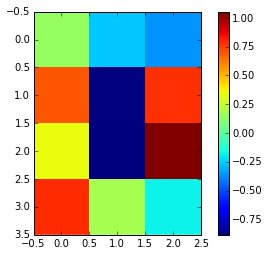

In [303]:
P = 3
C = 4
N = 100
s2 = 0.5
x = np.linspace(0,N-1,N)
phi = np.random.normal(loc=0,scale=1,size=(C,P))
print "Phi\n",phi
plt.imshow(phi,interpolation='none')
plt.colorbar()

### Kernel classes to be used to generate differnet Kernels for latent processes
#### We keep one with high and one low length scale to distinguish between them easily

In [242]:
class Kernel:
    @staticmethod
    def fetchParams(intializations,passed):
        params ={}
        for param in intializations:
            if param in passed:
                params[param] = passed[param]
            else:
                params[param] = intializations[param]
        return params
    
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    
    @staticmethod
    def periodic(x,xprime,**kwargs):
        initializations = { 'a':1,
                            'p':0.5,
                            'l':0.5}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*np.exp((-2*np.sin(np.pi* np.abs(x - xprime)/(params['p']))**2)/(params['l']**2))
        
    @staticmethod
    def linear(x,xprime,**kwargs):
        initializations = { 'a': 0.3}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*(x*xprime)
    
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(x[i],xprime[j],**kwargs)
        return np.mat(kernel)

<matplotlib.colorbar.Colorbar instance at 0x7f5ec647d908>

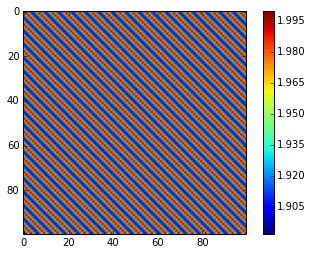

In [300]:
K = list()
K.append(Kernel.generateKernel(Kernel.periodic,x,x,a=2,l=6,p=6))
K.append(Kernel.generateKernel(Kernel.linear,x,x,a=0.005))
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=5))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1))
imshow(K[0],interpolation=None)       
plt.colorbar()

0
1
2


 /home/nautiys1/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


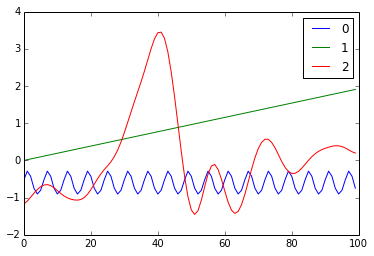

In [301]:
#Latent Gaussian Processes:
u = np.zeros((P,N))
for p in range(P):
    print p
    u[p,:] = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=K[p])
    plt.plot(u[p,:],label=p)
plt.legend()

#### Generate data :


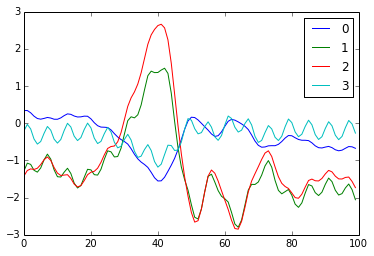

In [304]:
# Output Values:
s2 = 0
Y = phi.dot(u) + s2
for c in range(C):
    plt.plot(Y[c,:],label=c)
plt.legend()

## Now objective is to variationally approximate and recover Phi 

Variational Inducing Updates are:


### Intialization for variational updaes

- Select random inducing points {Needs to be optimized later}
- Generate Kernels 
- Phi Prior: N(0,I)
- uHatMeans Just random PXn values sampled form N(0,1) 
- uExp: Just random PXN values sampled form N(0,1)

In [319]:
## get random inducing point
## Intialization for variational inference
P=3
noOfInductions = 70
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
sparseY = np.mat(Y[:,n.astype(int)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=1,a=1))
    KNn.append(Kernel.generateKernel(Kernel.exponenQuad,x,n,l=1,a=1))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1,a=1))
    KnnInv.append(np.linalg.inv(Knn[i]))
    print KNn[i].shape,Knn[i].shape,KnnInv[i].shape
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
#phiHatExp = phi
phiHatVar = np.eye(P)
uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
uHatVs = [np.eye(noOfInductions)for p in range(P)]
uExp = np.random.normal(loc=0,scale=1,size=(P,N))
uVar = [np.eye(N) for p in range(P)]
Ups = [np.eye(N) for p in range(P)]
Zps = [np.zeros(N) for p in range(P)]


(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)


### Initial Guesses:
    

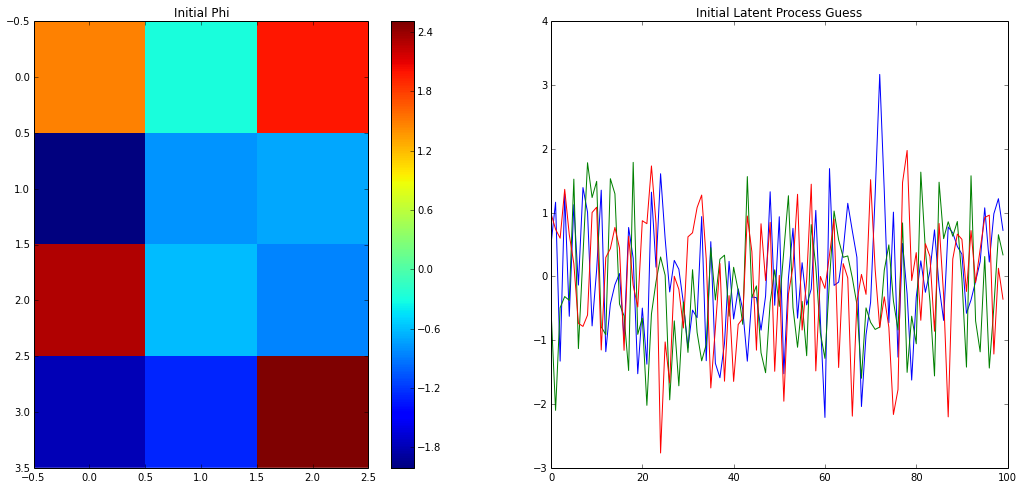

In [320]:
def displayGuesses(phiHatExp,uExp):
    fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize=(18,8))
    im = axes[0].imshow(phiHatExp,interpolation='None')
    plt.colorbar(im,ax=axes[0])
    axes[0].set_title("Initial Phi")

    for p in range(P):
        
        axes[1].plot(x,uExp[p])
        axes[1].set_title("Initial Latent Process Guess")
displayGuesses(phiHatExp,uExp)

### Variational Updates are:

#### For U's:

$q(\hat{u}_p) \propto N(\Sigma_{p}^{-1}K_{n}^{-1}K_{Nn}Z_p,\Sigma_{p}^{-1})$
where $\Sigma_{p} = K_{n}^{-1} + \frac{1}{\sigma^2}K_{n}^{-1}K_{nN}F_pK_{Nn}K_{n}^{-1}$


and $Z_p = \sum_{c}^{C}<\phi_{cp}>(y_c - \sum_{i}^{P/p}<\phi_{ci}><u_{ip}>)$, 
and $F_p = \sum_{c}^{C}<\phi_{cp}^2>$

$<\phi_{cp}^2> = var(\phi_{cp}) - <\phi_{cp}>^2$ 


Also,Actual U is:

${q(u) \propto N (K_{Nn}K_{n}^{-1}\hat{\mu}_{p}, \Sigma_{u|u^{p}} + M\Sigma_{p}M^{T})}$


where $\hat{\mu}_{p}$ is the mean of $\hat{u}_p$

and  $\Sigma_{u|u^{p}} = K_{N} - K_{Nn}K_{n}^{-1}K_{nN}$ , $M = K_{Nn}K_{n}^{-1}$

#### For $\phi$:

$$\phi = N(yU^{T}\Sigma_{\phi}^{-1}, \Sigma_{\phi}^{-1})$$
where $\Sigma_{\phi} = (V_{\phi} + I )$
and $V_{\phi} = <U><U>^T\sigma^2$

### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}z_p| 0, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$




In [321]:
#Calculate likelihood ofr single Up
def calculateLikelihood(p):
    uInv = np.linalg.inv(Ups[p])
    covMul = KNn[p]*KnnInv[p]*KNn[p].T
    logNterm = sum(MNormalDist.logpdf(x=uInv*Zps[p].T, mean=  np.zeros((N)),cov=uInv +covMul )) 
    summationForTrace = np.zeros((N,N))
    for i in range(P):
        covUiHat = KNN[i] - KNn[i]*KnnInv[i]*KNn[i].T
        summationForTrace += Ups[i]*covUiHat
    likl = logNterm - 0.5*np.matrix.trace(summationForTrace) 
    return likl

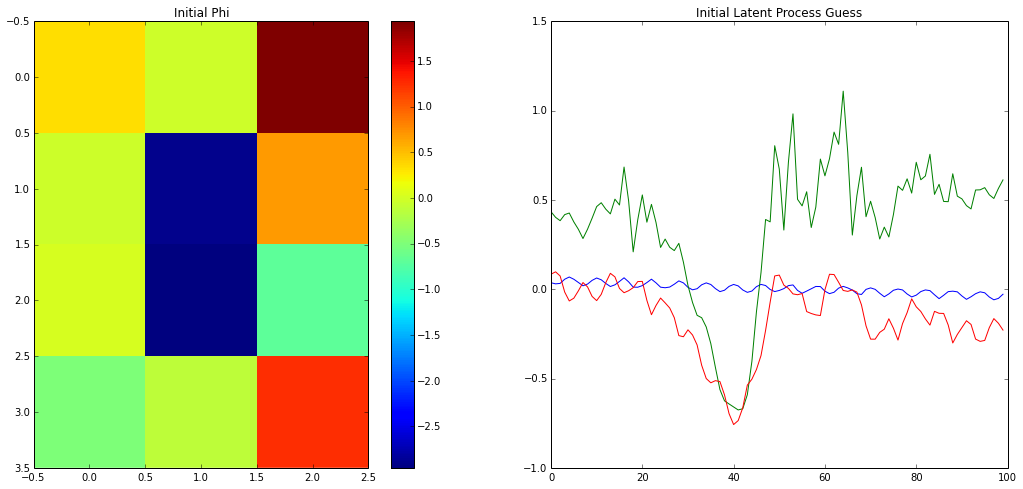

In [325]:
likelihoods = list()
for i in range(1000):
    #Variational Update for Up:
    likl = list()
    for p in range(P):
        #Find Up and Zp
        excludeP = np.arange(P)!=p
        #print i,p
        Zp = (phiHatExp[:,p].T.dot(Y - phiHatExp[:,excludeP]*uExp[excludeP,:])).reshape(1,N)
        phiSqHatExp = C*phiHatVar[p,p] + phiHatExp[:,p].T.dot(phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        Ups[p] = Up
        Zps[p] = Zp
        KNKnInv = KNn[p]*KnnInv[p]
        SigmaP = KnnInv[p] + KNKnInv.T * Up *KNKnInv
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T).reshape(noOfInductions,1)
        SigmaPInv = np.linalg.inv(SigmaP)
        uHatVs[p] = SigmaPInv
        uExp[p] = (KNKnInv*uHatMeans[p]).reshape(1,N)
        SigmaUGvUp = KNN[p] - KNKnInv * KNn[p].T
        uVar[p] = SigmaUGvUp + KNKnInv*SigmaPInv*KNKnInv.T
        #likl.append(calculateLikelihood(p))
    ## Variational Update for Phi
    Vf= uExp.dot(uExp.T)
    SigmaPhi = np.linalg.inv(Vf + np.eye(P))
    phiHatExp = np.mat(Y) * uExp.T * SigmaPhi
    phiHatVar = SigmaPhi
    likelihoods.append(calculateLikelihood(p))
    #likelihoods.append(likl)
displayGuesses(uExp=uExp,phiHatExp=phiHatExp)

## Reconstruct the data :

In [326]:
uHatMeans.shape

(3, 70, 1)

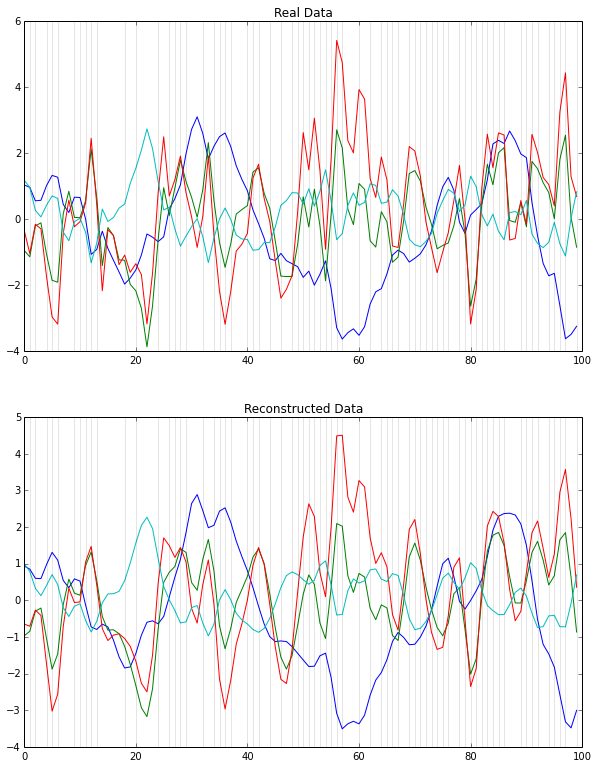

In [294]:
Ynew = phiHatExp * uExp
minVal = min(np.amin(Y),np.amin(Ynew)) 
maxVal = max(np.amax(Y),np.amax(Ynew)) 
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
axes[0].plot(Y.T)
axes[0].set_title('Real Data')
i=[axes[0].axvline(i,alpha=0.1,c='k') for i in n]
axes[1].plot(Ynew.T)
axes[1].set_title('Reconstructed Data')
i=[axes[1].axvline(i,alpha=0.1,c='k') for i in n]

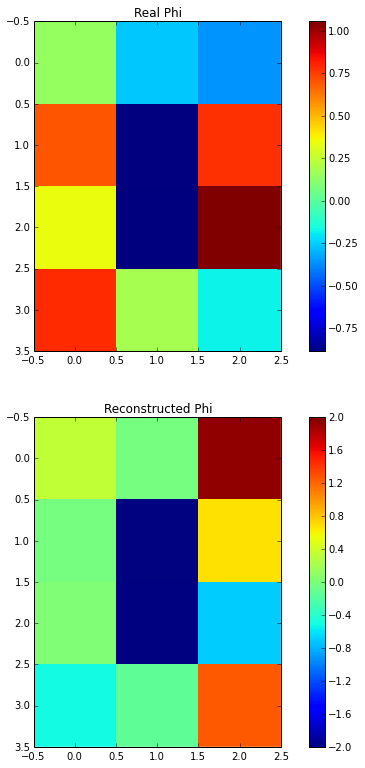

In [323]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
im = axes[0].imshow(phi, interpolation="None")
plt.colorbar(im,ax=axes[0])
axes[0].set_title('Real Phi')
#axes[0].scatter(n,np.zeros(n.size))
im = axes[1].imshow(phiHatExp, interpolation = "None",vmin=-2.0,vmax = 2.0)
plt.colorbar(im,ax=axes[1])
axes[1].set_title('Reconstructed Phi')
#plt.colorbar(fig)

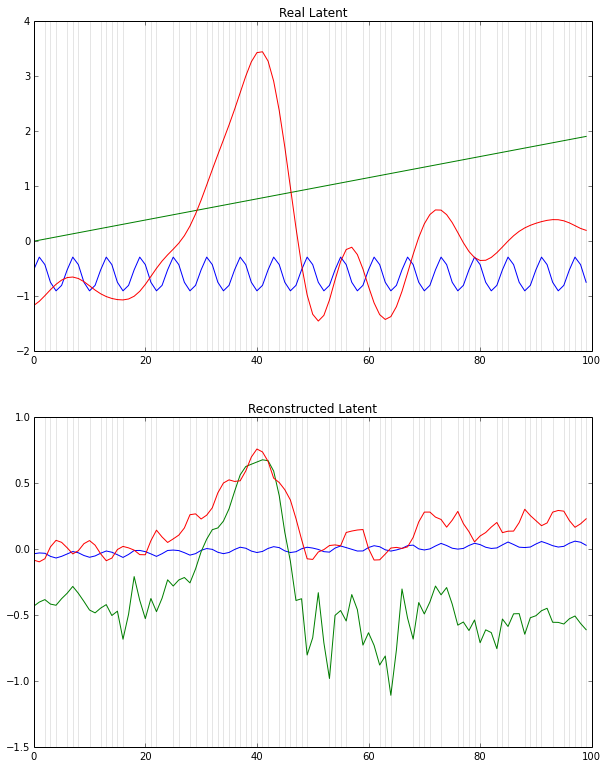

In [324]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
axes[0].plot(u.T)
axes[0].set_title('Real Latent')
i=[axes[0].axvline(i,alpha=0.1,c='k') for i in n]
axes[1].plot(-uExp.T)
axes[1].set_title('Reconstructed Latent')
std = np.sqrt(np.diag(uVar[p]))
i=[axes[1].axvline(i,alpha=0.1,c='k') for i in n]

## Optimization of hyper paramters

#### Parameters are optimized by maximizing the marginal likelihood and finding the gradient

We know that marginal likelihood is 

$L(u_p) = log N(F_{p}^{-1}z_p| 0, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$

Notes: Here we try to use the kernels from GPy so that gradients are easy to find. 

In [191]:
sqrt(np.diag(uHatVs[0]))

array([  1.18360243e+01,   2.86648234e+01,   1.10381542e+02,
         2.29365935e+02,   2.30663807e+02,   1.07080225e+02,
         9.49639053e+01,   9.35941565e+02,   3.13770763e+03,
         6.09339640e+03,   8.29376581e+03,   8.09788866e+03,
         4.95504176e+03,   4.53367211e+03,   6.70814955e+03,
         6.05619210e+03,   3.68224923e+03,   1.29466400e+03,
         2.06061555e+02,   7.63391172e+01,   1.11400617e+02,
         1.34506832e+02,   5.01048384e+02,   1.40716997e+03,
         2.02073134e+03,   1.57692083e+03,   1.87647625e+03,
         2.90763409e+03,   2.54682361e+03,   1.24555052e+03,
         4.99054643e+02,   3.19972654e+02,   8.33403212e+01,
         1.13857685e+02,   1.42165494e+02,   1.07584506e+02,
         9.24298081e+02,   3.38322651e+03,   6.95225763e+03,
         1.00567862e+04,   1.08703865e+04,   8.62406289e+03,
         4.28521615e+03,   2.33486955e+03,   2.29219119e+03,
         9.90754034e+02,   3.48654242e+02,   8.92493053e+02,
         6.55035785e+03,

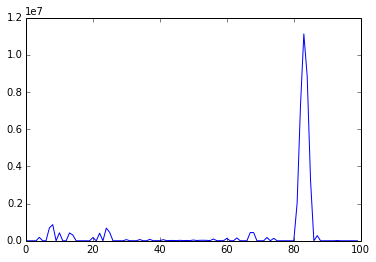

In [149]:
plt.plot(sd)
plt.plot(x,np.ones(len(x))*4, c='red')
#plt.plot(sd)
plt.show()

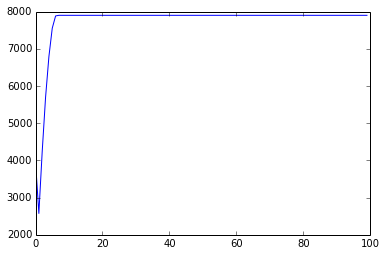

In [122]:
plt.plot(likelihoods*np.ones(len(likelihoods))*(-1))

#### Here we see that even though RBF kernel is used in the prior gusesses it is able to figure out the linear and periodic structure in the data